# COMPAS Recidivism Dataset - Fairness Analysis

This notebook evaluates fairness vs information retention trade-offs on the ProPublica COMPAS dataset.

**Dataset**: COMPAS Recidivism (~7,000 samples)

**Sensitive Attribute**: Race (African-American vs Others)

**Task**: Predict recidivism within 2 years

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from datasets import load_compas, get_dataset_summary
from fairness_metrics import compute_all_fairness_metrics, compute_performance_metrics
from preprocessing import Reweighing, FeatureMasking, DisparateImpactRemover, LabelFlipping, SamplingStrategy
from inprocessing import FairnessRegularizedClassifier, AdversarialDebiasing, ConstrainedClassifier
from postprocessing import EqualizedOddsPostProcessor, ThresholdOptimizer, CalibratedPostProcessor, RejectOptionClassifier
from visualization import plot_accuracy_fairness_tradeoff, plot_grouped_bar_chart, plot_pareto_frontier, create_summary_dashboard

print("Modules loaded successfully!")

Modules loaded successfully!


## 1. Data Loading & Exploration

In [2]:
data = load_compas(sensitive_attr='race', random_state=42)
summary = get_dataset_summary(data)
display(summary)

print(f"\nDataset: {data['metadata']['name']}")
print(f"Task: {data['metadata']['task']}")
print(f"Sensitive Attribute: {data['sensitive_attr']}")
print(f"Groups: {data['metadata']['sensitive_groups']}")

,Dataset,Task,N Train,N Test,N Features,Positive Rate (Train),Sensitive Attr,Group 0 Rate,Group 1 Rate,Group 0 Pos Rate,Group 1 Pos Rate,Disparate Impact
0,COMPAS,Recidivism prediction,4320,1852,7,45.51%,race,48.63%,51.37%,38.84%,51.83%,0.749



Dataset: COMPAS
Task: Recidivism prediction
Sensitive Attribute: race
Groups: {0: 'Other races', 1: 'African-American'}


In [3]:
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
sens_train, sens_test = data['sensitive_train'], data['sensitive_test']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Training samples: 4320
Test samples: 1852
Features: 7


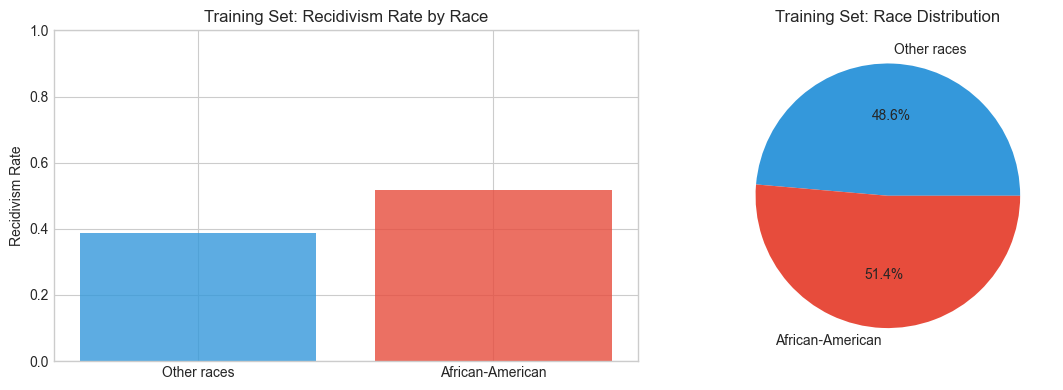

In [4]:
# Visualize target distribution by race
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for g, label in data['metadata']['sensitive_groups'].items():
    mask = sens_train == g
    pos_rate = y_train[mask].mean()
    ax.bar(label, pos_rate, color=['#3498DB', '#E74C3C'][g], alpha=0.8)
ax.set_ylabel('Recidivism Rate')
ax.set_title('Training Set: Recidivism Rate by Race')
ax.set_ylim(0, 1)

ax = axes[1]
sizes = [np.sum(sens_train == g) for g in data['metadata']['sensitive_groups'].keys()]
labels = list(data['metadata']['sensitive_groups'].values())
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#3498DB', '#E74C3C'])
ax.set_title('Training Set: Race Distribution')

plt.tight_layout()
plt.show()

## 2. Baseline Model

In [5]:
results = []

def evaluate_model(y_true, y_pred, y_prob, sensitive, method_name, category):
    perf = compute_performance_metrics(y_true, y_pred, y_prob)
    fair = compute_all_fairness_metrics(y_true, y_pred, y_prob, sensitive)
    return {
        'Method': method_name, 'Category': category,
        'Accuracy': perf['accuracy'], 'AUC': perf.get('auc', np.nan),
        'Precision': perf['precision'], 'Recall': perf['recall'], 'F1': perf['f1'],
        'DPD': fair['demographic_parity_difference'],
        'DPR': fair['demographic_parity_ratio'],
        'EOD': fair['equalized_odds_difference']['average'],
        'TPR_Diff': fair['equalized_odds_difference']['tpr_difference'],
        'FPR_Diff': fair['equalized_odds_difference']['fpr_difference']
    }

In [6]:
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)

y_pred_baseline = baseline_clf.predict(X_test)
y_prob_baseline = baseline_clf.predict_proba(X_test)[:, 1]

baseline_results = evaluate_model(y_test, y_pred_baseline, y_prob_baseline, sens_test, 'Baseline', 'Baseline')
results.append(baseline_results)

print("BASELINE RESULTS")
print(f"Accuracy: {baseline_results['Accuracy']:.4f}")
print(f"DPD: {baseline_results['DPD']:.4f}")
print(f"EOD: {baseline_results['EOD']:.4f}")

BASELINE RESULTS
Accuracy: 0.6857
DPD: 0.2561
EOD: 0.2129


## 3. Pre-processing Methods

In [7]:
# 3.1 Reweighing
reweigher = Reweighing()
reweigher.fit(X_train, y_train, sens_train)
clf_reweight = LogisticRegression(max_iter=1000, random_state=42)
clf_reweight.fit(X_train, y_train, sample_weight=reweigher.get_weights())
y_pred = clf_reweight.predict(X_test)
y_prob = clf_reweight.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, 'Reweighing', 'Pre-processing'))
print(f"Reweighing: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 3.2 Disparate Impact Remover
for rl in [0.5, 1.0]:
    dir_proc = DisparateImpactRemover(sensitive_attr_idx=0, repair_level=rl)
    dir_proc.fit(X_train, sensitive=sens_train)
    X_tr_dir = dir_proc.transform(X_train, sens_train)
    X_te_dir = dir_proc.transform(X_test, sens_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr_dir, y_train)
    y_pred = clf.predict(X_te_dir)
    y_prob = clf.predict_proba(X_te_dir)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'DIR (r={rl})', 'Pre-processing'))
    print(f"DIR (r={rl}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 3.3 Label Flipping
for strategy in ['targeted', 'equalize']:
    flipper = LabelFlipping(flip_rate=0.1, strategy=strategy)
    flipper.fit(X_train, y_train, sens_train)
    y_flipped = flipper.transform(y_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_flipped)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'LabelFlip ({strategy})', 'Pre-processing'))
    print(f"LabelFlip ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 3.4 Sampling
for strategy in ['oversample', 'undersample', 'hybrid']:
    sampler = SamplingStrategy(strategy=strategy)
    X_res, y_res, s_res = sampler.fit_resample(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Sampling ({strategy})', 'Pre-processing'))
    print(f"Sampling ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Reweighing: Acc=0.6847, DPD=0.2545
DIR (r=0.5): Acc=0.6863, DPD=0.2158
DIR (r=1.0): Acc=0.6857, DPD=0.1688
LabelFlip (targeted): Acc=0.6803, DPD=0.2501
LabelFlip (equalize): Acc=0.6836, DPD=0.2490
Sampling (oversample): Acc=0.6739, DPD=0.2799
Sampling (undersample): Acc=0.6712, DPD=0.2717
Sampling (hybrid): Acc=0.6836, DPD=0.2828


## 4. In-processing Methods

In [8]:
# 4.1 Fairness Regularized
for lf in [0.1, 0.5, 1.0, 2.0]:
    clf = FairnessRegularizedClassifier(lambda_fairness=lf, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'FairReg (λ={lf})', 'In-processing'))
    print(f"FairReg (λ={lf}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 4.2 Adversarial Debiasing
for aw in [0.5, 1.0]:
    try:
        clf = AdversarialDebiasing(adversary_weight=aw, n_epochs=50, use_pytorch=True)
        clf.fit(X_train, y_train, sens_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Adversarial (w={aw})', 'In-processing'))
        print(f"Adversarial (w={aw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")
    except Exception as e:
        print(f"Adversarial (w={aw}) failed: {e}")

# 4.3 Constrained
for th in [0.05, 0.1]:
    clf = ConstrainedClassifier(constraint_threshold=th, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, f'Constrained (ε={th})', 'In-processing'))
    print(f"Constrained (ε={th}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

FairReg (λ=0.1): Acc=0.6388, DPD=0.1619
FairReg (λ=0.5): Acc=0.6377, DPD=0.1577
FairReg (λ=1.0): Acc=0.6371, DPD=0.1546
FairReg (λ=2.0): Acc=0.6355, DPD=0.1431
Adversarial (w=0.5): Acc=0.6890, DPD=0.2605
Adversarial (w=1.0): Acc=0.6928, DPD=0.2753
Constrained (ε=0.05): Acc=0.6836, DPD=0.2487
Constrained (ε=0.1): Acc=0.6825, DPD=0.2489


## 5. Post-processing Methods

In [9]:
y_prob_train = baseline_clf.predict_proba(X_train)[:, 1]

# 5.1 Equalized Odds
eo = EqualizedOddsPostProcessor(objective='equalized_odds')
eo.fit(y_train, y_prob_train, sens_train)
y_pred = eo.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, 'Equalized Odds', 'Post-processing'))
print(f"Equalized Odds: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 5.2 Threshold Optimizer
for fw in [0.3, 0.5, 0.7]:
    to = ThresholdOptimizer(fairness_weight=fw)
    to.fit(y_train, y_prob_train, sens_train)
    y_pred = to.transform(y_prob_baseline, sens_test)
    results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, f'ThreshOpt (w={fw})', 'Post-processing'))
    print(f"ThreshOpt (w={fw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 5.3 Calibrated
cal = CalibratedPostProcessor(n_bins=10)
cal.fit(y_train, y_prob_train, sens_train)
y_prob_cal = cal.transform(y_prob_baseline, sens_test)
y_pred = (y_prob_cal >= 0.5).astype(int)
results.append(evaluate_model(y_test, y_pred, y_prob_cal, sens_test, 'Calibrated', 'Post-processing'))
print(f"Calibrated: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

# 5.4 Reject Option
priv_group = 1 if y_train[sens_train == 1].mean() > y_train[sens_train == 0].mean() else 0
ro = RejectOptionClassifier(privileged_group=priv_group)
ro.fit(y_train, y_prob_train, sens_train)
y_pred = ro.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, y_pred, y_prob_baseline, sens_test, 'Reject Option', 'Post-processing'))
print(f"Reject Option: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Equalized Odds: Acc=0.6253, DPD=0.0593
ThreshOpt (w=0.3): Acc=0.6857, DPD=0.2561
ThreshOpt (w=0.5): Acc=0.6857, DPD=0.2561
ThreshOpt (w=0.7): Acc=0.6857, DPD=0.2561
Calibrated: Acc=0.6852, DPD=0.2571
Reject Option: Acc=0.6674, DPD=0.0326


## 6. Results Summary

In [10]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,DPR,EOD,TPR_Diff,FPR_Diff
14,Adversarial (w=1.0),In-processing,0.692765,NaN,0.707576,0.553974,0.621424,0.275254,0.437729,0.229984,0.307677,0.152291
13,Adversarial (w=0.5),In-processing,0.688985,NaN,0.696613,0.561091,0.621551,0.260535,0.471186,0.214030,0.274698,0.153363
2,DIR (r=0.5),Pre-processing,0.686285,NaN,0.707937,0.529063,0.605567,0.215766,0.514653,0.170346,0.236767,0.103925
18,ThreshOpt (w=0.3),Post-processing,0.685745,NaN,0.710145,0.523132,0.602459,0.256080,0.442341,0.212884,0.286610,0.139158
19,ThreshOpt (w=0.5),Post-processing,0.685745,NaN,0.710145,0.523132,0.602459,0.256080,0.442341,0.212884,0.286610,0.139158
0,Baseline,Baseline,0.685745,NaN,0.710145,0.523132,0.602459,0.256080,0.442341,0.212884,0.286610,0.139158
3,DIR (r=1.0),Pre-processing,0.685745,NaN,0.702326,0.537367,0.608871,0.168756,0.607469,0.120775,0.175931,0.065619
20,ThreshOpt (w=0.7),Post-processing,0.685745,NaN,0.710145,0.523132,0.602459,0.256080,0.442341,0.212884,0.286610,0.139158
21,Calibrated,Post-processing,0.685205,NaN,0.709003,0.523132,0.602048,0.257126,0.441335,0.214008,0.286610,0.141406
1,Reweighing,Pre-processing,0.684665,NaN,0.714760,0.511269,0.596127,0.254548,0.432755,0.212564,0.291886,0.133242


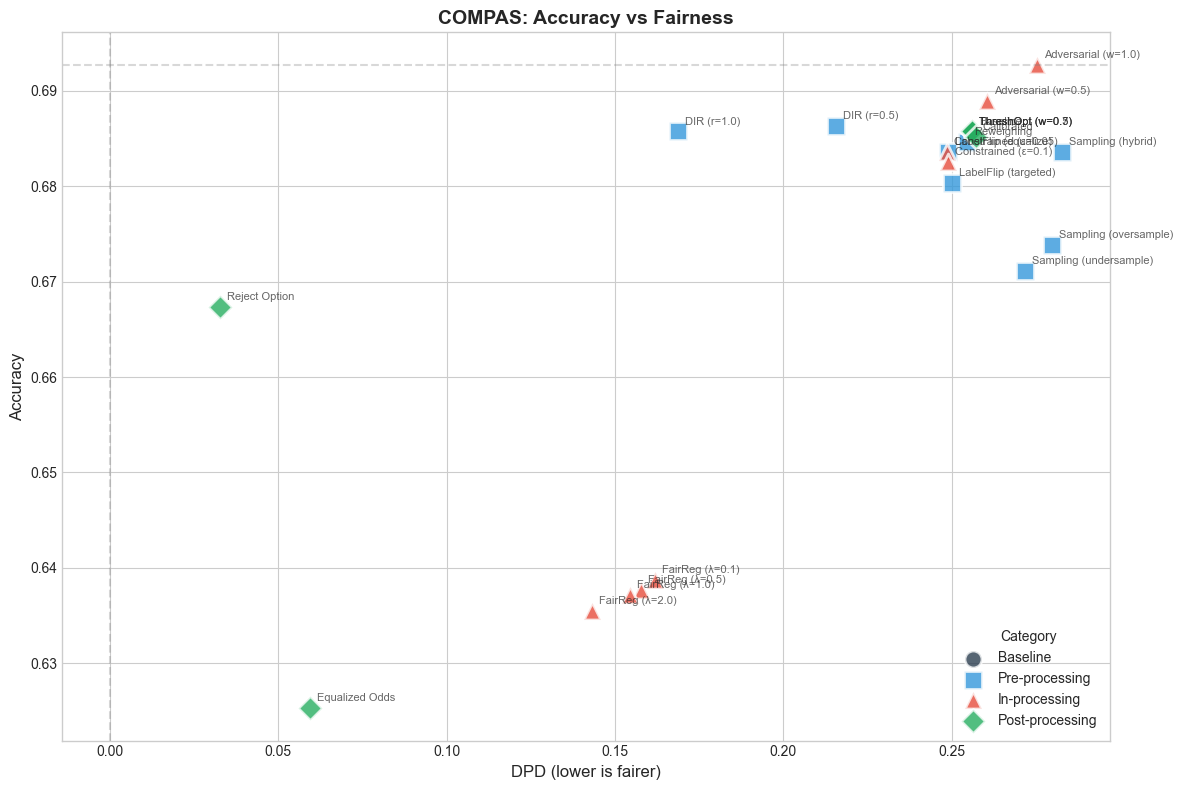

In [11]:
fig = plot_accuracy_fairness_tradeoff(results_df, title='COMPAS: Accuracy vs Fairness')
plt.show()

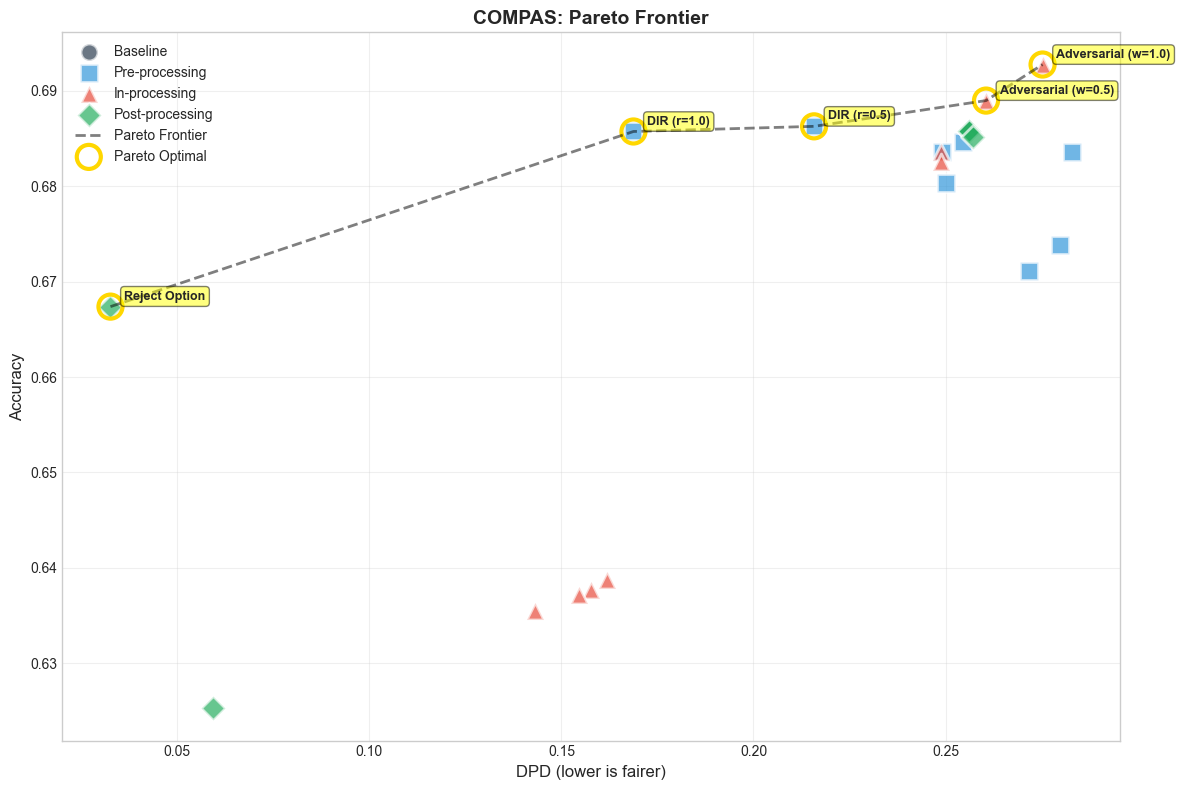

In [12]:
fig = plot_pareto_frontier(results_df, title='COMPAS: Pareto Frontier')
plt.show()

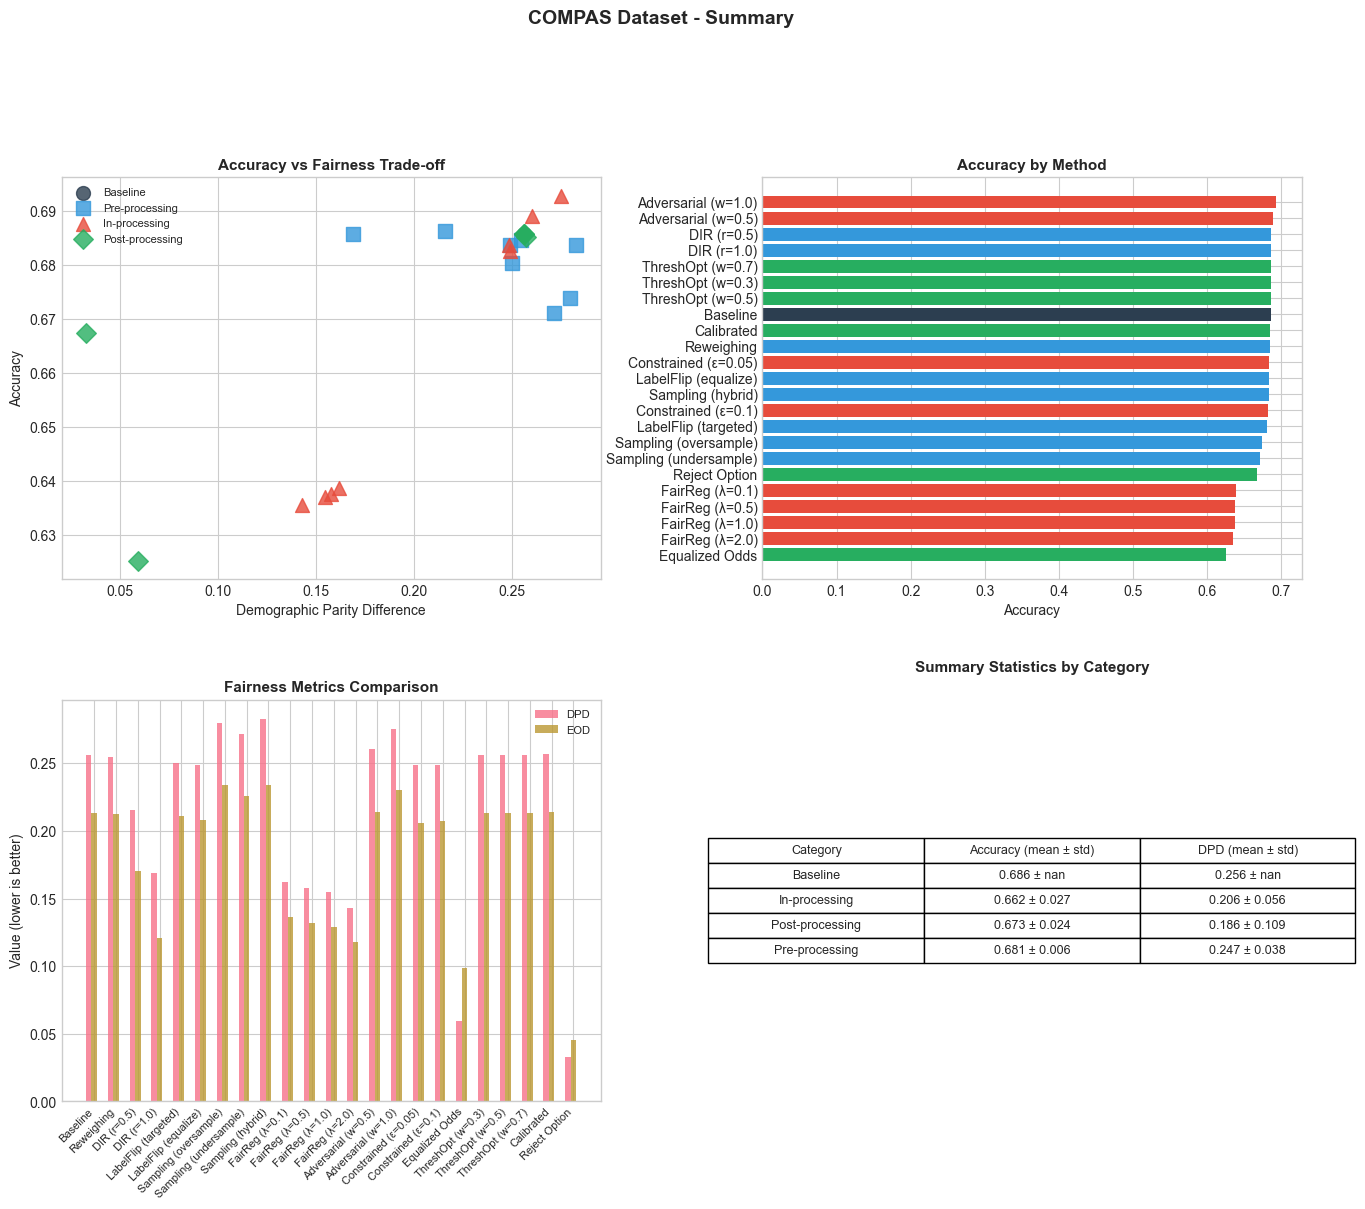

In [13]:
fig = create_summary_dashboard(results_df, title='COMPAS Dataset - Summary')
plt.show()

In [14]:
results_df.to_csv('../results/compas_results.csv', index=False)
print("Results saved!")

Results saved!
